C:\Users\28274\AppData\Local\Temp\ipykernel_34724\3338533209.py:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  base_cmap = cm.get_cmap('YlGnBu')


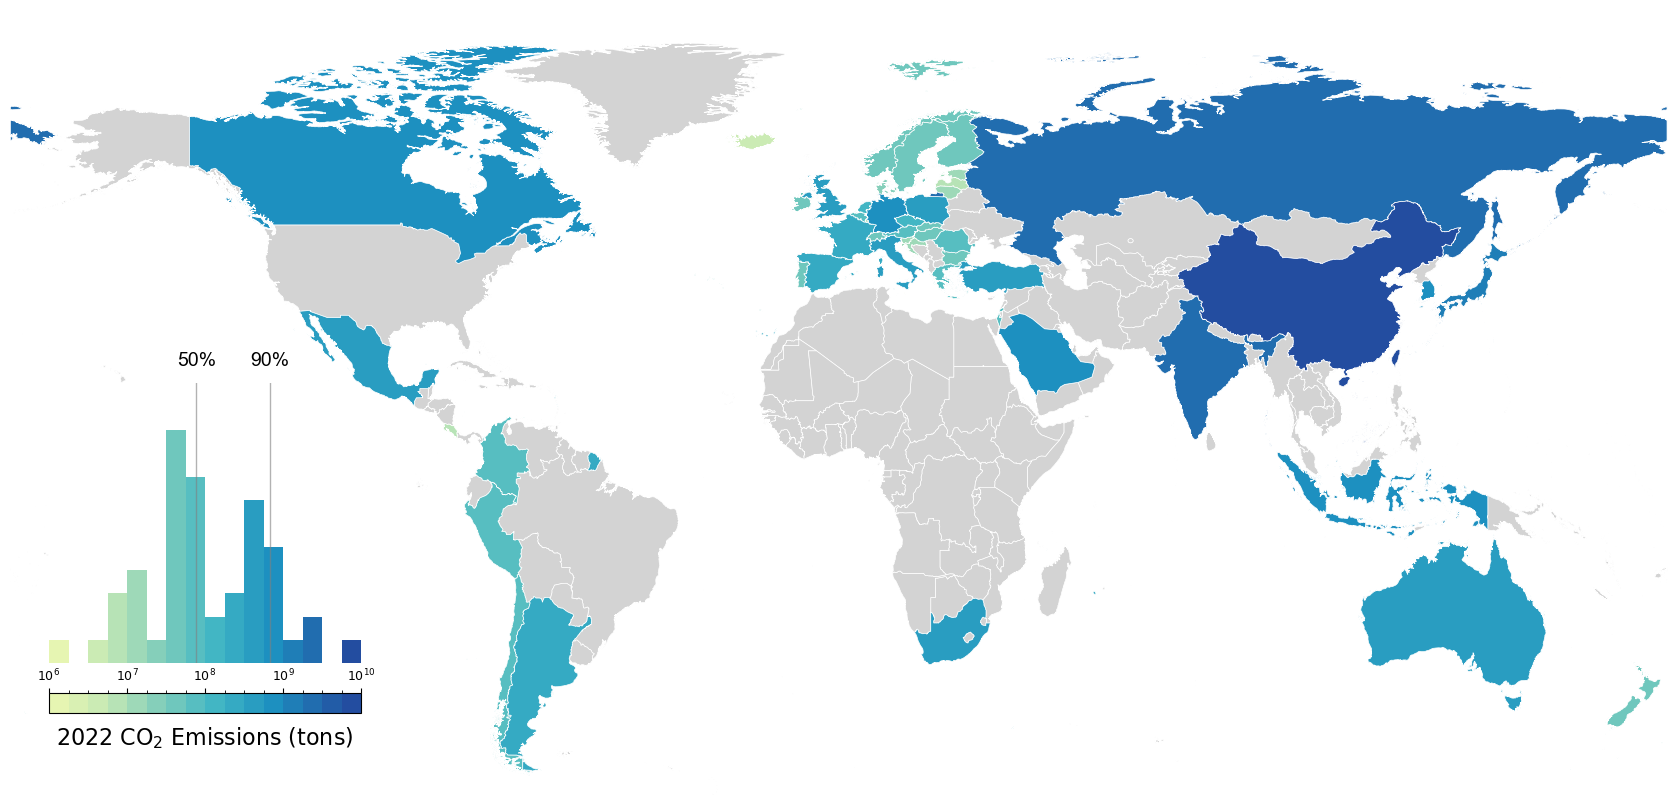

In [13]:
import geopandas as gpd  
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.colorbar import ColorbarBase
import matplotlib.cm as cm

# 读取数据
shp_path = r"F:\Desktop\CAMPF_Supplementary\data_origin\global_shp\global_ems.shp"
gdf = gpd.read_file(shp_path)

# 确保使用等距圆柱投影
gdf = gdf.to_crs('EPSG:4326')

# 分离0值和非0值数据
gdf_zero = gdf[gdf['2022_CO_Em'] == 0].copy()
gdf_nonzero = gdf[gdf['2022_CO_Em'] > 0].copy()

# 裁掉南纬60°以南
gdf_zero = gdf_zero.cx[-180:180, -60:90]
gdf_nonzero = gdf_nonzero.cx[-180:180, -60:90]

# 创建离散的 YlGnBu 色带
n_bins = 16  # 改为16
base_cmap = cm.get_cmap('YlGnBu')
discrete_colors = [base_cmap(i) for i in np.linspace(0.15, 0.8, n_bins)]
cmap = ListedColormap(discrete_colors)

# === 强制设置数据范围为 10^6 到 10^10 ===
force_min = 1e6
force_max = 1e10

# 获取数据范围
if not gdf_nonzero.empty:
    # 强制使用固定的边界：10^6, 10^7, 10^8, 10^9, 10^10
    key_boundaries = [1e6, 1e7, 1e8, 1e9, 1e10]
    
    # 这5个边界将数据分成4段，每段分配4个bins
    bin_edges = []
    bins_per_segment = 4  # 16 bins / 4 segments = 4 bins per segment
    
    for i in range(len(key_boundaries) - 1):
        start = key_boundaries[i]
        end = key_boundaries[i + 1]
        segment = np.logspace(np.log10(start), np.log10(end), bins_per_segment + 1)
        if i == 0:
            bin_edges.extend(segment)
        else:
            bin_edges.extend(segment[1:])  # 避免重复边界
    
    bin_edges = np.array(bin_edges)
    
    # 裁剪数据：小于10^6的设为10^6，大于10^10的设为10^10
    gdf_nonzero['2022_CO_Em_clipped'] = gdf_nonzero['2022_CO_Em'].clip(lower=force_min, upper=force_max)
    
    # 为非0值分配离散的颜色类别
    gdf_nonzero['color_bin'] = pd.cut(gdf_nonzero['2022_CO_Em_clipped'], 
                                       bins=bin_edges, 
                                       labels=False, 
                                       include_lowest=True)
    
    # === 色条刻度：10^6, 10^7, 10^8, 10^9, 10^10 ===
    tick_positions = [1e6, 1e7, 1e8, 1e9, 1e10]
    tick_labels = ['$10^{6}$', '$10^{7}$', '$10^{8}$', '$10^{9}$', '$10^{10}$']

# 创建图形 - 使用默认白色背景
fig = plt.figure(figsize=(19.5, 10))

# 主地图区域
ax_map = fig.add_axes([0.1, 0.05, 0.85, 0.92])

# 绘制0值区域（灰色）
if not gdf_zero.empty:
    gdf_zero.plot(ax=ax_map, 
                  color='#D3D3D3', 
                  edgecolor='white', 
                  linewidth=0.5)

# 绘制非0值区域 - 使用离散颜色分类
if not gdf_nonzero.empty:
    for i in range(n_bins):
        subset = gdf_nonzero[gdf_nonzero['color_bin'] == i]
        if not subset.empty:
            subset.plot(ax=ax_map, 
                       color=discrete_colors[i], 
                       edgecolor='white', 
                       linewidth=0.5)

ax_map.set_xlim(-180, 180)
ax_map.set_ylim(-60, 90)
ax_map.axis('off')

# 色条和直方图
if not gdf_nonzero.empty:
    # 色条位置（在图形中稍微上移一些，以便显示上方的刻度）
    cax = fig.add_axes([0.12, 0.2, 0.16, 0.02])
    
    # 使用离散色带和边界归一化
    norm = BoundaryNorm(bin_edges, ncolors=n_bins)
    cb = ColorbarBase(cax, cmap=cmap, norm=norm, orientation='horizontal')
    
    # 设置色条刻度 - 强制使用指定的10的幂次方
    cb.set_ticks(tick_positions)
    cb.set_ticklabels(tick_labels)
    
    # 设置色条刻度的方向为向上
    cb.ax.tick_params(labelsize=9, rotation=0)  # 修改为0度，刻度数字向上显示
    
    # 将色条的刻度放置在**上方**
    cb.ax.xaxis.set_ticks_position('top')  # 将刻度移到色条上方
    
    # "2022 CO₂ Emissions" 标注紧贴色条下方
    cb.set_label('2022 CO$_2$ Emissions (tons)', fontsize=16, labelpad=8)
    
    # 直方图区域
    ax_hist = fig.add_axes([0.12, 0.25, 0.16, 0.28])
    
    # 使用裁剪后的数据
    data_values = gdf_nonzero['2022_CO_Em_clipped'].values
    
    # 使用 np.histogram 统计数据
    counts, _ = np.histogram(data_values, bins=bin_edges)
    
    # 将 counts 数值放大 10 倍
    counts = counts * 10

    # 为每个bin绘制彩色方块 - 去掉边框
    for i, (left, right, count) in enumerate(zip(bin_edges[:-1], bin_edges[1:], counts)):
        color = discrete_colors[i]
        ax_hist.fill_between([left, right], 0, count, 
                            color=color, 
                            edgecolor='none',  # 去掉边框
                            linewidth=0)
    
    # 百分位数线 - 改成50%和90%，灰色，字体更大
    # 注意：这里使用原始数据计算百分位数
    percentiles = [50, 90]
    percentile_values = np.percentile(gdf_nonzero['2022_CO_Em'].values, percentiles)
    # 同样裁剪百分位数值
    percentile_values = np.clip(percentile_values, force_min, force_max)
    percentile_labels = ['50%', '90%']
    
    y_max = counts.max() * 1.2
    for pct_val, pct_label in zip(percentile_values, percentile_labels):
        ax_hist.axvline(x=pct_val, color='#808080', linestyle='-',  # 灰色
                       linewidth=1.0, alpha=0.6)
        ax_hist.text(pct_val, y_max * 1.05, pct_label,
                    fontsize=14,  # 字体更大
                    ha='center', va='bottom', 
                    fontfamily='Arial',  # Arial字体
                    weight='normal')  # 不加粗
    
    # 设置直方图样式 - 强制使用10^6到10^10的范围
    ax_hist.set_xlim(force_min, force_max)
    ax_hist.set_xscale('log')
    ax_hist.set_ylim(0, y_max)
    
    # 隐藏Y轴和边框
    ax_hist.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
    ax_hist.tick_params(axis='y', which='both', left=False, labelleft=False)
    ax_hist.spines['top'].set_visible(False)
    ax_hist.spines['right'].set_visible(False)
    ax_hist.spines['left'].set_visible(False)
    ax_hist.spines['bottom'].set_visible(False)
    ax_hist.grid(False)

plt.savefig(r'F:\Desktop\CAMPF_Supplementary\data\CO2_emissions_map.png', 
            dpi=600,                    # 高分辨率
            bbox_inches='tight',        # 自动裁剪空白边距
            facecolor='white',          # 白色背景
            edgecolor='none')

plt.show()
